<font color='red'><font size=7>
 
 **WP-SN-1: Supernovae detection on images**</font></font>

<font color='red'><font size=6>
 
 **Our job :**</font></font>


 From the initial images dataset you are requested to develop and implement algorithms allowing to **detect supernovae on the images**. You are welcome to propose your own algorithms and you can also discuss with the teacher about your ideas and follow his advices to improve your ideas. You will be given basic tools to read the images and the list of objects that are in them. 

 Note that the images are **not intercalibrated in time meaning that the flux in each pixel of the image does not have the same meaning in term of photometric magnitude for each image**. You need to perform the calibration by yourself. For this you are expected to use the stars peresent on each image for which the magnitude is known. The measurement of their magnitude in the image will be perform a tool which has to be provided to your WP by WP-SN-2.

 Note also that the images are **not taken under the same *seeing* conditions meaning that a point source is not seen as a Gaussian with the same width in each image** due to atmospheric turbulence. You are requested to correct for this effect providing a program that transforms the images to the same *seeing* before making the subtraction.

 * *Input data:*
 
    * Images of the various fields at different epochs
    * List of galaxies and stars for each image with their respective location, magnitudes, redshifts etc...
    * Seeing measured on each image

 * *Informations/tools form other WP:*

    * Program to perform the photrometry of a point-source in an image given its location and providing apparent magnitude (calibrated in absolute) - **provided by WP-SN-2**

 * <font color='red'>*Deliverables:*

    * List of SN candidates along with their redshifts for each field.
    * Intercalibration of the images, absolute photometric calibration of the dataset (to give to WP-SN-2)
    * Program to perform the difference of two images accounting for different seeing (to give to WP-SN-2).</font>

Let import some useful packages.

In [0]:
#### Some usual imports
from pylab import *
from matplotlib import rc
%matplotlib inline
rc('figure',figsize=(17,10))
rc('font',size=12)
rc('text',usetex=False)
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import cmath as cm
import math
import random
import scipy
from scipy.stats import norm
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
import pandas
pandas.options.display.float_format = '{:,.2f}'.format
import glob


#### Reading file from Google Drive
!pip install PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
!pip install photutils

     |████████████████████████████████| 983kB 2.7MB/s 


We will work on the following datasets :

0.   **Test-Data**: smaller images, contains the supernova and their lightcurves. This is intended to serve as a test for you as you have here the answers. It contains files that you will have for the "true" datasets:

 * image of a field with galaxies, stars and supernovae at different epochs. They are given as FITS files (see below for examples to read them). The filename contains information on the date in days.
 * Stars in the image - as a CSV file to be read with pandas
 * Galaxies in the image - as a CSV file to be read with pandas
 * PSF.txt : a file containing the Full-Width-Half-Maximum for each image (in arcsec)

 as well as files you will not have for the "true" datsets:
 * Supernovae in the image - as a series of CSV files containing all supernovae in each image along with their apparent magnitudes. To be read with pandas.
 * intercal.txt : a file containing the actual intercalibration beteween images (read with numpy.loadtxt)
 * datemax.txt : a file containing the date of maximum for each supernova.

1.   **Data-Search** : Dataset designed for detecting supernovae. It contains data at different epochs for 5 different fields (the number of the field is encoded in the filenames)

 * image of a field with galaxies, stars and supernovae at different epochs. They are given as FITS files (see below for examples to read them). The filename contains information on the date in days.
 * Stars in the image - as a CSV file to be read with pandas
 * Galaxies in the image - as a CSV file to be read with pandas
 * PSF.txt : a file containing the Full-Width-Half-Maximum for each image (in arcsec)

In [0]:
##### For Test Data that contains also the true values...
download = drive.CreateFile({'id': '1QeWXTbwe60QuH06l18IJ45wv2eBgg62C'})
download.GetContentFile('Test-Data.tgz')
!tar zxvf Test-Data.tgz
#La commande "tar" permet de rassembler plusieurs fichiers pour les stocker dans un fichier unique, non compressé.

##### For Data-Search (WP-SN-1):
download = drive.CreateFile({'id': '1F1mFRZFAFCEJumipFGoJr8TJb6oc7naI'})
download.GetContentFile('Data-Search.tgz')
!tar zxvf Data-Search.tgz

### On vient de créer 2 directory : Test-Data et Data-Search


!ls -lrt

./._Test-Data
Test-Data/
Test-Data/EI2019-Test-Data-Field-0_images_epoch_21.58_.fits
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_ 0.53_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_21.58_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_-7.89_.csv
Test-Data/EI2019-Test-Data-Field-0_intercal.txt
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_-3.68_.csv
Test-Data/EI2019-Test-Data-Field-0_images_epoch_23.68_.fits
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_ 2.63_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_23.68_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_19.47_.csv
Test-Data/._Icon\r
Test-Data/Icon\r
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_-1.58_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_27.89_.csv
Test-Data/EI2019-Test-Data-Field-0_SNs_epoch_13.16_.csv
Test-Data/EI2019-Test-Data-Field-0_images_epoch_15.26_.fits
Test-Data/EI2019-Test-Data-Field-0_images_epoch_17.37_.fits
Test-Data/EI2019-Test-Data-Field-0_images_epoch_19.47_.fits
Test-Data/EI2019-Test-Data-Fiel

We give a name to some files, in order to give examples of plots, but of course you can call the functions with the files you want.

In [0]:
directory = 'Test-Data/'
globalname = 'EI2019-Test-Data-Field-0'
files = glob.glob(directory+globalname+'_images_epoch_*.fits')

directory2 = 'Data-Search/'
globalname2 = 'EI2019-Data-Search-Field-3'

# <font color='red'>**I. Intercalibration**</font>

We calculate the intercalibration of our images, so that the flux in each pixel has the same meaning in term of photometric magnitude for each image. We can choose the reference image arbitrarily ; we just want to **standardize the flux of all the images**, but it may correspond to a "wrong" magnitude. The absolute correction for the magnitude will be provided below.

We can start with the intercalibration (and not necessary the correction of the seeing) since, in order to compute the flux of a star, we chose a **radius that is proportional to the psf** of the image.

The intercalibration is the mean of the ratios between the flux of the stars computed on the reference image and an other image.

We compute the fluxes of the stars (ie the integral of the star in the image unit) with the aperture photometry technique : we compute the integral of the star in the image unit (on a surface that depends on the psf of the image) and we subtract the background by computing its value on an annulus around the star. We did this code ourselves and we also tested the one provided by SN2, which gives the same results.

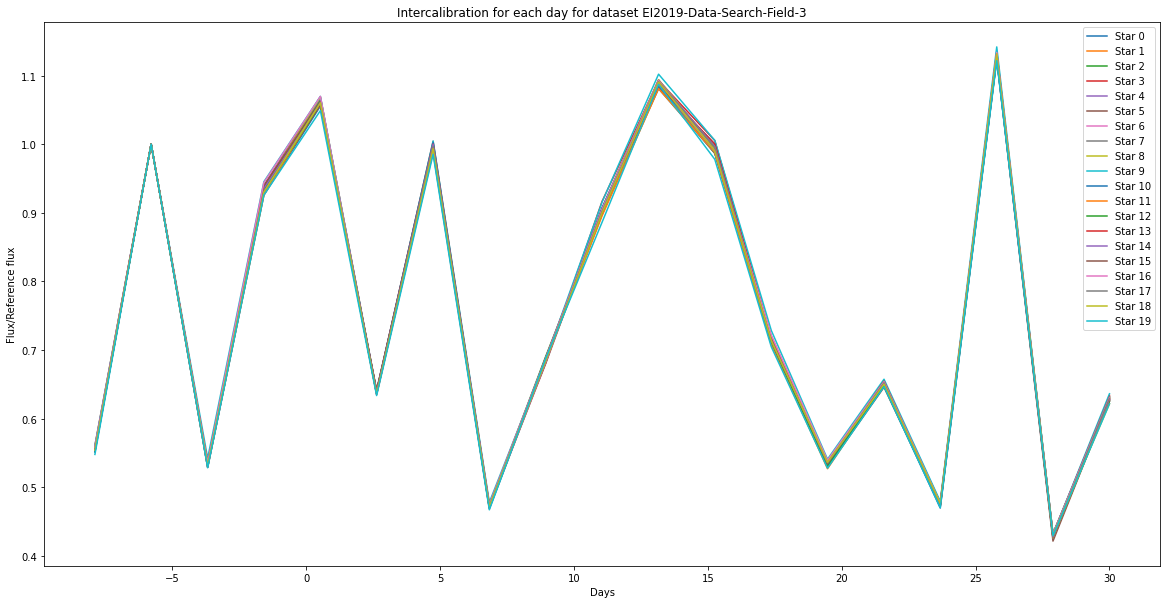

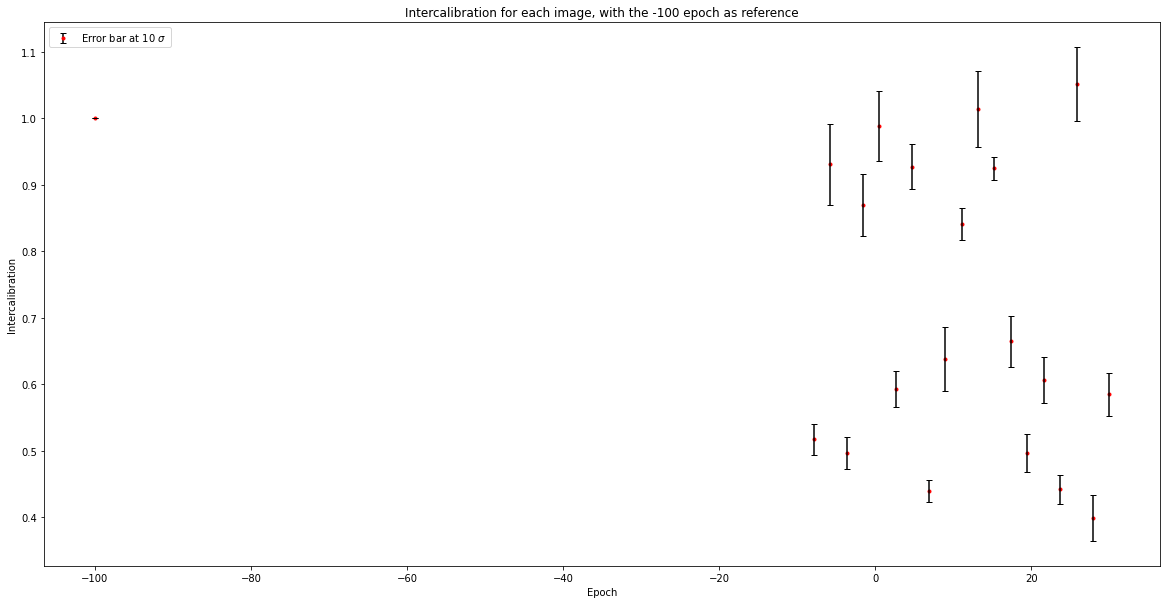

([1.0743803071321034,
  0.5553779725607293,
  1.0,
  0.5330357324004034,
  0.9345238926821615,
  1.0621575802256944,
  0.6374666195540347,
  0.9961961681196437,
  0.4721056926300508,
  0.6859159869567476,
  0.9038824532280106,
  1.089367832212073,
  0.9934353585165342,
  0.7140411097509723,
  0.533039646051147,
  0.65113844114182,
  0.4744729057422618,
  1.129883386266313,
  0.42840375802296254,
  0.6282696799134135],
 [0.006972749621883607,
  0.0033999585407797233,
  0.0,
  0.0032729120006491047,
  0.006165158770419071,
  0.005440903600210816,
  0.001999731395841799,
  0.004688689584070986,
  0.002362703806299624,
  0.0024821931289320063,
  0.006617033321988247,
  0.005398698801315528,
  0.006669517636505785,
  0.005725734132578026,
  0.003626677403192046,
  0.003784403803878381,
  0.002223524861688193,
  0.0054132180494225485,
  0.002567785481291406,
  0.004130868797108439])

In [0]:
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry

def intercal(directory, globalname, reference, show_plot=False):
  """Donne les valeurs de l'intercalibration de chaque image du dossier choisi, en choisissant pour référence l'image d'indice reference, ainsi que son écart-type (la valeur renvoyée étant la moyenne sur toutes les étoiles de l'image)"""

  files = glob.glob(directory+globalname+'_images_epoch_*.fits')

  epochs_img = np.zeros(len(files))
  for i in range(len(files)):
      name = files[i]
      bla = str.split(name,'_')
      epochs_img[i]= bla[-2]

  #### Sort according to epoch
  s = np.argsort(epochs_img)

  epochs = np.zeros(len(files))
  files_sorted = np.zeros_like(files)
  for i in range(len(files)):
    epochs[i] = epochs_img[s[i]]
    files_sorted[i] = files[s[i]]

  imref = fits.open(files_sorted[reference])[0].data
  psf = np.loadtxt(directory+globalname+"_PSF.txt")
  stars = pandas.read_csv(directory+globalname+"_stars.csv")

  ### On commence par calculer le flux de chaque étoile dans l'image de référence

  #aperture photometry : on fait la somme des voltages correspondant à notre étoile (ATTENTION à bien prendre un rayon proportionnel au PSF !), et on retire la valeur correspondant au background
  if (globalname[-1] == '2'):
    aperture = CircularAperture([(stars["x"][i], stars["y"][i]) for i in [j for j in range(len(stars)) if j != 19]], r=psf[reference]*10)
    annulus_aperture = CircularAnnulus([(stars["x"][i], stars["y"][i]) for i in [j for j in range(len(stars)) if j != 19]], r_in=10, r_out=15)
  else:
    aperture = CircularAperture([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r=psf[reference]*10)
    annulus_aperture = CircularAnnulus([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r_in=10, r_out=15)
    #on calcule la valeur du background dans un anneau autour de l'étoile, et on considère que cette valeur est similaire à celle pour l'emplacement de l'étoile
  aperture_tot = [aperture,annulus_aperture]

  phot_table = aperture_photometry(imref, aperture_tot)
  
  Vref = phot_table["aperture_sum_0"] - phot_table["aperture_sum_1"]*aperture.area/annulus_aperture.area
  #Liste de la somme des voltages de chaque étoile de l'image de référence

  fluxes = []   #liste de listes donnant V/Vref de chaque image, ie donne le facteur correctif de chaque étoile de chaque image

  ### On calcule le flux de chaque étoile dans toutes les autres images

  for ii in range(len(files_sorted)):
    image = fits.open(files_sorted[ii])[0].data

    if (globalname[-1] == '2'): #We have to manage an outlier in this dataset
      aperture = CircularAperture([(stars["x"][i], stars["y"][i]) for i in [j for j in range(len(stars)) if j != 19]], r=psf[ii]*10)
      annulus_aperture = CircularAnnulus([(stars["x"][i], stars["y"][i]) for i in [j for j in range(len(stars)) if j != 19]], r_in=10, r_out=15)
    else:
      aperture = CircularAperture([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r=psf[ii]*10)
      annulus_aperture = CircularAnnulus([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r_in=10, r_out=15)
    aperture_tot = [aperture,annulus_aperture]
    phot_table = aperture_photometry(image, aperture_tot)
    V = phot_table["aperture_sum_0"] - phot_table["aperture_sum_1"]*aperture.area/annulus_aperture.area
    fluxes.append(V/Vref)

  if show_plot:
    plt.figure(figsize=(20,10))
    for ii in range(len(files_sorted)):
      #if (globalname[-1] != '2' or ii != 19):
      flux = [fluxes[j][ii] for j in range(1,len(epochs))]
      plot(epochs[1:], flux, label="Star "+str(ii))
    xlabel("Days")
    ylabel("Flux/Reference flux")
    title("Intercalibration for each day for dataset " + globalname)
    legend()

    plt.figure(figsize=(20,10))
    errorbar(epochs, exemple, yerr=10*np.array(incert_exemple), fmt='r.', ecolor='k', barsabove=True, capsize = 3, label="Error bar at 10 $\sigma$")
    xlabel("Epoch")
    ylabel("Intercalibration")
    title("Intercalibration for each image, with the -100 epoch as reference")
    legend()
    show()

  intercalibration = []
  incert_intercalibration = []
  for i in range(len(files_sorted)):
    intercalibration.append(mean(fluxes[i]))
    incert_intercalibration.append(std(fluxes[i]))

  return(intercalibration, incert_intercalibration)

### Exemple de l'intercalibration pour ce fichier
intercal(directory2, globalname2, 2, show_plot=True)


Since we have the values of the intercalibration, we just have to divide our images by the corresponding factor, so that the images are intercalibrated :

In [0]:
def files_intercalibrated(directory, globalname, reference):
  """renvoie la liste des images intercalibrées, en utilisant pour référence l'image d'indice reference"""

  files = glob.glob(directory+globalname+'_images_epoch_*.fits')

  epochs_img = np.zeros(len(files))
  for i in range(len(files)):
      name = files[i]
      bla = str.split(name,'_')
      epochs_img[i]= bla[-2]

  #### Sort according to epoch
  s = np.argsort(epochs_img)

  epochs = np.zeros(len(files))
  files_sorted = np.zeros_like(files)
  for i in range(len(files)):
    epochs[i] = epochs_img[s[i]]
    files_sorted[i] = files[s[i]]

  intercalib = intercal(directory, globalname, reference)[0]
  files_calibrated = []
  for i in range(len(files_sorted)):
    im = fits.open(files_sorted[i])[0].data
    files_calibrated.append(im/intercalib[i])
  return(files_calibrated)


We can compare the **standard deviation of the mean flux and of the mean magnitudes** of all the stars across the different epochs BEFORE the intercalibration and AFTER.

This mean (on all the stars of an image) doesn't have any particular physical meaning, but it should be constant across the different epochs if the intercalibration and the seeing were "perfect" (since the apparent magnitude of a star shouldn't change).

We see that the standard deviation is much more (x10) lower after the intercalibration, which means that the fluxes were successfully standardized.

In [0]:
def comparaison(directory, globalname, reference):
  ##affiche les écart-type des flux et des magnitudes sur les images non intercalibrées et sur les images intercalibrées

  files = glob.glob(directory+globalname+'_images_epoch_*.fits')

  epochs_img = np.zeros(len(files))
  for i in range(len(files)):
      name = files[i]
      bla = str.split(name,'_')
      epochs_img[i]= bla[-2]

  #### Sort according to epoch
  s = np.argsort(epochs_img)

  epochs = np.zeros(len(files))
  files_sorted = np.zeros_like(files)
  for i in range(len(files)):
    epochs[i] = epochs_img[s[i]]
    files_sorted[i] = files[s[i]]

  psf = np.loadtxt(directory+globalname+"_PSF.txt")
  stars = pandas.read_csv(directory+globalname+"_stars.csv")

  flux_tot = []
  magnitude = []

  ###We compute the fluxes before the intercalibration (aperture photometry)
  for i in range(len(files_sorted)):
    aperture = CircularAperture([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r=psf[reference]*10)
    annulus_aperture = CircularAnnulus([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r_in=5., r_out=10.)
    aperture_tot = [aperture,annulus_aperture]

    phot_table = aperture_photometry(fits.open(files_sorted[i])[0].data, aperture_tot)
    
    V = phot_table["aperture_sum_0"] - phot_table["aperture_sum_1"]*aperture.area/annulus_aperture.area
    flux_tot.append(mean(V))
    magn = 0
    for j in range(len(V)):
      magn += -2.5*log10(V[j])
    magnitude.append(magn/len(V))



  print("Sans intercalibration, l'écart-type sur le flux total moyen de toutes les étoiles chaque jour est ", np.std(flux_tot))
  #print(magnitude)
  print("Sans intercalibration, l'écart-type sur la moyenne des magnitudes apparentes de tous les étoiles chaque jour est ",np.std(magnitude))

  flux_tot_calibre = []
  magnitude_finale = []

  ###We do the same computing but on the calibrated images :
  for i in range(len(files_sorted)):
    aperture = CircularAperture([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r=psf[reference]*10)
    annulus_aperture = CircularAnnulus([(stars["x"][i], stars["y"][i]) for i in range(len(stars))], r_in=5., r_out=10.)
    aperture_tot = [aperture,annulus_aperture]

    phot_table = aperture_photometry(files_intercalibrated(directory, globalname, reference)[i], aperture_tot)
    
    V = phot_table["aperture_sum_0"] - phot_table["aperture_sum_1"]*aperture.area/annulus_aperture.area
    flux_tot_calibre.append(mean(V))
    magn = 0
    for j in range(len(V)):
      magn += -2.5*log10(V[j])
    magnitude_finale.append(magn/len(V))

  print("AVEC intercalibration, l'écart-type sur le flux total moyen de toutes les étoiles chaque jour est ", np.std(flux_tot_calibre))

  #print(flux_tot_calibre)
  #print(magnitude_finale)
  print("AVEC intercalibration, l'écart-type sur la moyenne des magnitudes apparentes de tous les étoiles chaque jour est ", np.std(magnitude_finale))


###An example :
comparaison(directory, globalname, 3)


Sans intercalibration, l'écart-type sur le flux total moyen de toutes les étoiles chaque jour est  54869.038773838045
Sans intercalibration, l'écart-type sur la moyenne des magnitudes apparentes de tous les étoiles chaque jour est  0.26519273514438707
AVEC intercalibration, l'écart-type sur le flux total moyen de toutes les étoiles chaque jour est  18355.312847813508
AVEC intercalibration, l'écart-type sur la moyenne des magnitudes apparentes de tous les étoiles chaque jour est  0.06614059601115511


# <font color='red'>**II. Seeing**</font>

Our images **don't have the same blurring** due to turbulent mixing in the atmosphere of Earth. That means that a point source is not seen as a Gaussian with the same width in each image. Before doing the subtraction of two images, we therefore need to correct it, so that the images have the same seeing.

When the seeing is the same, we can do the subtraction of the reference image from an other one. **Unlike stars and galaxies, supernovae are transient events, which make their detection possible by looking for brightness variation between those two images**.

We plot two results of the difference of two images : one without paying attention to the seeing, and the second with a corrected seeing. We see that in the first case, some points appear on the locations of stars and galaxies, and could be incorrectly recognized as SNe !

In [0]:
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.stats import gaussian_sigma_to_fwhm

files = glob.glob(directory+globalname+'_images_epoch_*.fits')

epochs_img = np.zeros(len(files))
for i in range(len(files)):
    name = files[i]
    bla = str.split(name,'_')
    epochs_img[i]= bla[-2]

#### Sort according to epoch
s = np.argsort(epochs_img)

epochs = np.zeros(len(files))

for i in range(len(files)):
  epochs[i] = epochs_img[s[i]]

###We open the file of the stars in the Test dataset
###We also open the file with the supernovae in order to check our results
galaxies = pandas.read_csv(directory+globalname+'_galaxies.csv')
stars = pandas.read_csv(directory+globalname+'_stars.csv')
all_sns = []
for i in range(len(epochs)):
  all_sns.append(pandas.read_csv(directory+globalname+'_SNs_epoch_{0:5.2f}_.csv'.format(epochs[i])))




Text(0.5, 1.0, 'Difference bewteen two images (intercalibrated and same seeing)')

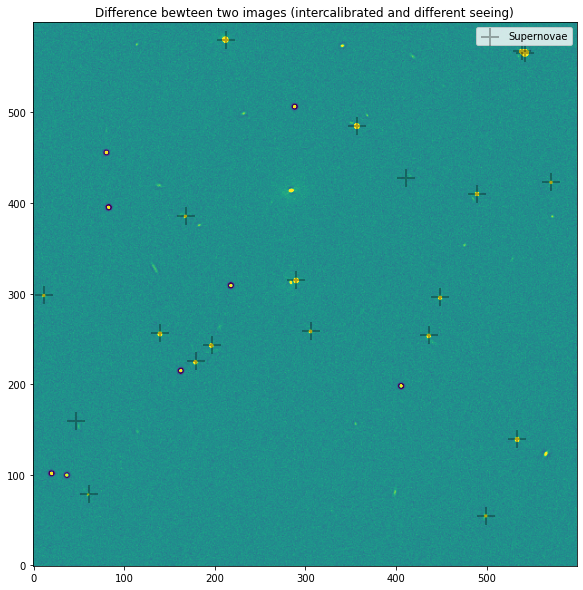

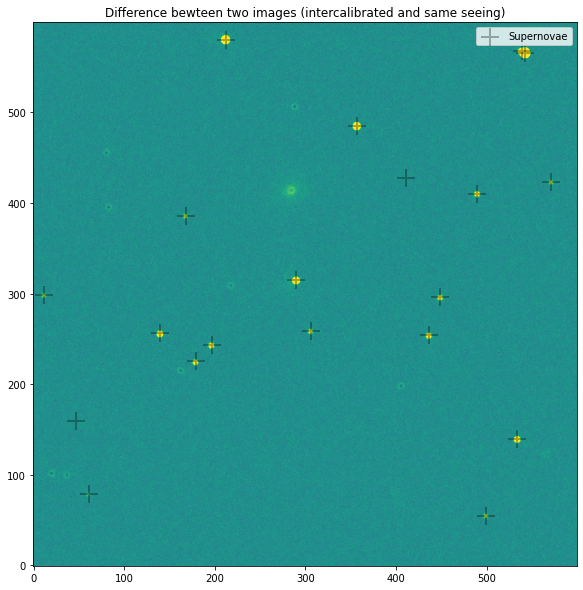

In [0]:
def normalize_psf(directory, globalname, i1, i2,reference,adjust=0.1): 
  """Take two images (of indice i1 and i2), transform them so that they have the same seeing (the worst of the two), and take the image with the reference indice as a reference for the intercalibration"""
  files = files_intercalibrated(directory, globalname, reference)
  psf = np.loadtxt(directory+globalname+"_PSF.txt")

  image_1 = files[i1]
  image_2 = files[i2]
  sigma_1 = psf[i1]*(10)/(2*sqrt(2*log(2)))
  sigma_2 = psf[i2]*(10)/(2*sqrt(2*log(2)))
  if sigma_1 < sigma_2:
    sigma = sqrt(sigma_2**2 - sigma_1**2)
    ker = Gaussian2DKernel(x_stddev=sigma+adjust) 
    new_image_1 = convolve(image_1,ker,normalize_kernel=True)
    return(new_image_1,image_2,sigma_2)
  else:
    sigma = sqrt(sigma_1**2 - sigma_2**2)
    ker = Gaussian2DKernel(x_stddev=sigma+adjust) 
    new_image_2 = convolve(image_2,ker,normalize_kernel=True)
    return(image_1,new_image_2,sigma_1)

def diff_images(directory, globalname, i1, i2,reference):
  """Do the difference between two images by changing their seeing to the same one and taking the image with indice reference as the reference of the intercalibration"""
  im1,im2,s = normalize_psf(directory, globalname, i1, i2,reference)
  return(im2-im1,s)

imagefinale = diff_images(directory,globalname,0,1,0)

plt.figure(figsize=(10,10))
imshow(files_intercalibrated(directory, globalname, 0)[1]-files_intercalibrated(directory, globalname, 0)[0], origin='lower',vmin= -0.3*np.std(imagefinale[0]), vmax = 0.3*np.std(imagefinale[0]))
plt.scatter(np.around(all_sns[0]['x'].values), np.around(all_sns[0]['y'].values), 
            s=300, marker='+', color='k', lw=2,
            label='Supernovae', alpha = 0.3)
legend()
plt.title('Difference bewteen two images (intercalibrated and different seeing)')

plt.figure(figsize=(10,10))
imshow(imagefinale[0], origin='lower',vmin= -0.3*np.std(imagefinale[0]), vmax = 0.3*np.std(imagefinale[0]))
plt.scatter(np.around(all_sns[0]['x'].values), np.around(all_sns[0]['y'].values), 
            s=300, marker='+', color='k', lw=2,
            label='Supernovae', alpha = 0.3)
legend()
plt.title('Difference bewteen two images (intercalibrated and same seeing)')

# <font color='red'> **III. Absolute correction for the magnitude**</font>

We just needed all the images to have the same flux for a given star in order to do the subtraction, but **as we chose arbitrarily the reference, we don't have the "right" magnitude on our images**.

**WP-SN-3 needs to have the exact magnitude** to compute those of the supernovae.

To do so, we calculate the **magnitude of the stars** on our images, and as we know their real magnitude, we can compute the difference between those values. We compute the mean of those differences on all our images (to have a more robust result) : this is the additionnal correction that we have to add in order to compute the real magnitude of all the objects of our image (including supernovae). This correction is the absolute correction for the magnitude.

In [0]:
def calculate_magnitude(image, positions, psf, r_in=5, r_out = 8):
  """Gives the magnitude of an object in a given image at a given position"""
  circular_aperture = CircularAperture(positions, r=psf*10)
  annulus_aperture = CircularAnnulus(positions, r_in=r_in, r_out=r_out)
  aperture=[circular_aperture, annulus_aperture]

  phot_table = aperture_photometry(image, aperture)

  flux = phot_table["aperture_sum_0"] - phot_table["aperture_sum_1"]*circular_aperture.area/annulus_aperture.area
  magnitude = -2.5*np.log10(flux)

  return magnitude

Correction pour le dataset EI2019-Data-Search-Field-3 : 36.48 ± 0.04


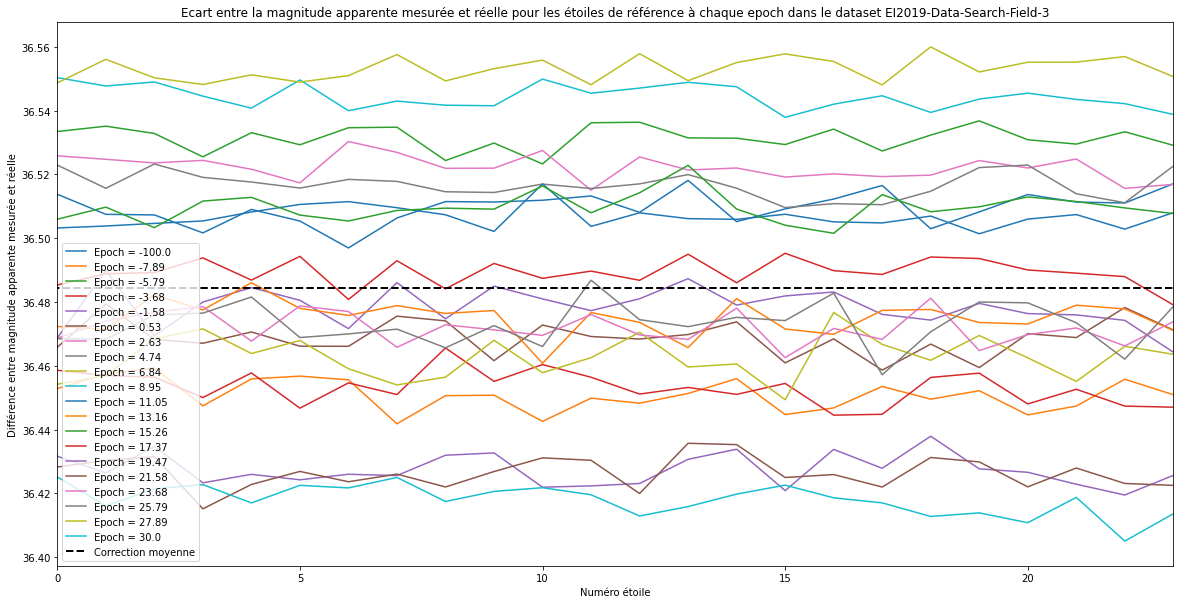

(36.48444575192049, 0.03808305428655382)

In [0]:
def corr_magnitude(directory, globalname, reference):
  """Computes the mean correction that is needed on the magnitude on a given image"""
  psf = np.loadtxt(directory+globalname+"_PSF.txt")
  stars = pandas.read_csv(directory+globalname+"_stars.csv")
  files = files_intercalibrated(directory, globalname, reference)

  filenames = glob.glob(directory+globalname+'_images_epoch_*.fits')
  corr_epoch =  []

  epochs_img = np.zeros(len(files))
  for i in range(len(files)):
      name = filenames[i]
      bla = str.split(name,'_')
      epochs_img[i]= bla[-2]

  #### Sort according to epoch
  s = np.argsort(epochs_img)

  epochs = np.zeros(len(files))
  for i in range(len(files)):
    epochs[i] = epochs_img[s[i]]
  
  plt.figure(figsize=(20,10))
  for i in range(len(files)):
    image = files[i]

    if globalname == 'EI2019-Data-Search-Field-2': #on traite à part ce dataset à cause de l'outlier 19
      X = [j for j in range(len(stars)) if j != 19]
      magnitudes = calculate_magnitude(image, [(stars["x"][i], stars["y"][i]) for i in X], psf[i]*2)
      Y = stars.drop(19)["magnitudes"] - magnitudes #correction de la magnitude pour toutes les étoiles de l'image courante

    else:
      X = range(len(stars))
      magnitudes = calculate_magnitude(image, [(stars["x"][i], stars["y"][i]) for i in X], psf[i]*2)
      Y =stars["magnitudes"] - magnitudes
    
    corr_epoch.append(mean(Y)) #moyenne des corrections de magnitude sur toutes les étoiles, époque par époque
    plot(X,Y, label="Epoch = "+str(epochs[i])) #plot la correction des magnitudes pour chaque étoile et pour chaque époque

  corr = np.mean(corr_epoch) #moyenne des corrections sur toutes les époques dans ce dataset (normalement celles-ci doivent être proches car la magnitude des étoiles ne doit pas changer)
  incert_corr = np.std(corr_epoch) #incertitude sur la correction sur les époques

  print("Correction pour le dataset "+globalname +" : "+ "%.2f" %corr + " ± " "%.2f" %incert_corr)
  
  plot([-5,25], [corr, corr], color="k", linestyle='dashed', linewidth = 2, label="Correction moyenne")
  ylabel("Différence entre magnitude apparente mesurée et réelle")
  xlabel("Numéro étoile")
  xlim((0,23))
  title("Ecart entre la magnitude apparente mesurée et réelle pour les étoiles de référence à chaque epoch dans le dataset "+globalname)
  legend()
  show()
  
  return(corr, incert_corr)

corr_magnitude(directory2, globalname2,2)

# <font color='red'>**IV. Finding Supernovae**</font>

Now that our images are "cleaner", we can find the supernovae on them by subtracting the reference image (on this image, we assume that there is no transient object, only stars and galaxies).

We use the **DBSCAN algorithm** (a cluster algorithm) that detects the positions where the resulting image has a value that differs a lot from the mean. This is the positions of the supernovae.

On the **Test Set, we have very good results** : no false positive, and we've miss only 2 SNe on 20 !

In [0]:
def distance(p1, p2):
  return(np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2))

def nettoyer_sn(SNe, directory, globalname, dist_max=20):
  galaxies = pandas.read_csv(directory+globalname+"_galaxies.csv")
  
  SN = [sn for sn in SNe if min([distance(sn, (galaxies["x"][i], galaxies["y"][i])) for i in range(len(galaxies))]) < dist_max]
  return(np.array(SN))

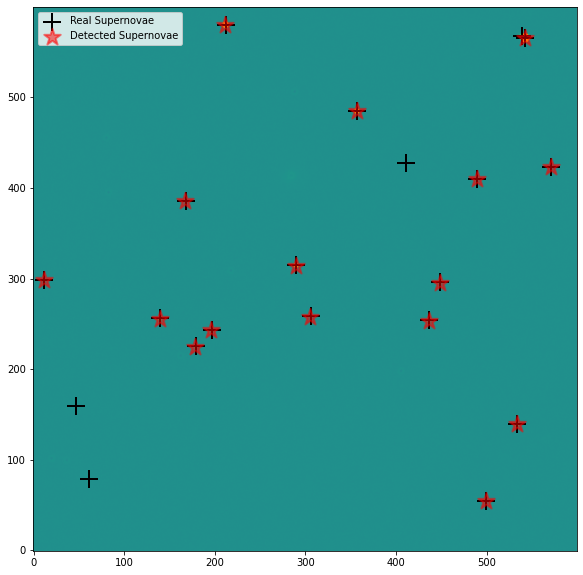

In [0]:
from astropy.stats import SigmaClip
from sklearn.cluster import DBSCAN

def find_SNe(image, directory, globalname):

  # Clip the pixels above the background
  sigclip = SigmaClip(sigma_lower = 1000, sigma_upper=10, maxiters=5)
  image_mask = np.array(ma.getmask(sigclip(image))) # Mask on the image that is True in the position of the cliped pixels and False otherwise

  # Transform the mask from an image format to an (X,Y) format getting only the significant (True) pixels
  X, Y = [], []
  for i in range(len(image_mask[0])):
    for j in range(len(image_mask[:,0])):
      if image_mask[i,j]==True:
        X.append(j)
        Y.append(i)
  XY = np.transpose(np.vstack((X,Y)))

  XY_pandas = pandas.DataFrame(XY) # Convert the data to a pandas dataframe in order to be able use DBSCAN

  # Use DBSCAN to find the clusters of pixels (the SNe)
  db = DBSCAN(eps=1, min_samples=3).fit(XY_pandas)
  labels = db.labels_

  # Separate the points of each SNe in the form (X,Y) without considering -1 points (noise)
  SNe_clusters = [[] for i in set(labels)-{-1}]
  for i in range(len(labels)):
    if labels[i]!=-1:
      SNe_clusters[labels[i]].append([XY[i][0],XY[i][1],image[XY[i][1]][XY[i][0]]])

  # Calculate the center of mass of each SNe (their coordinates)
  SNe = []
  for SN in SNe_clusters:
    SN_array = np.array(SN)
    SNe.append(average(SN_array[:,:2], axis=0, weights=SN_array[:,2]))
  return nettoyer_sn(np.array(SNe), directory, globalname)

SNe = find_SNe(diff_images(directory,globalname,0,4,3)[0], directory, globalname)

plt.figure(figsize=(10,10))
imshow(imagefinale[0], origin='lower',vmin= -3*np.std(imagefinale[0]), vmax = 3*np.std(imagefinale[0]))
plt.scatter(np.around(all_sns[0]['x'].values), np.around(all_sns[0]['y'].values), 
            s=300, marker='+', color='k', lw=2,
            label='Real Supernovae', alpha = 1)
plt.scatter(SNe[:,0], SNe[:,1], s=300, marker='*', color='r', lw=2, label='Detected Supernovae', alpha = 0.5)
legend()

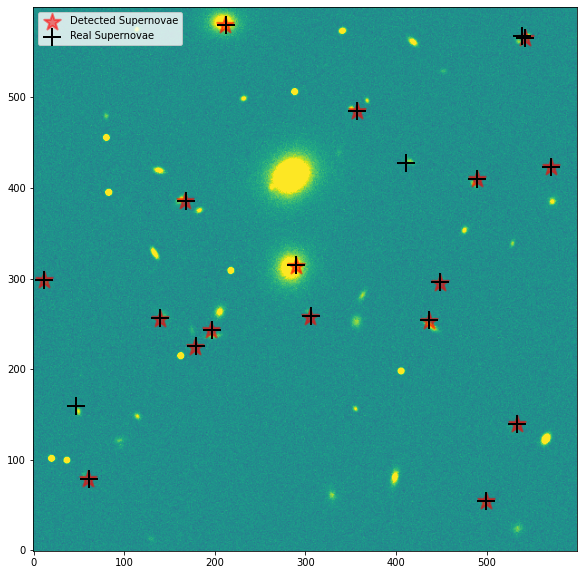

In [0]:
def clean_SNe(SNe):
  new_SNe = [SNe[0]]
  for SN in SNe[1:]:
    if np.min(scipy.spatial.distance.cdist([SN],new_SNe))>3:
      new_SNe.append([SN[0],SN[1]])
  return np.array(new_SNe)

def find_all_SNe(directory,globalname, reference):
  psf = np.loadtxt(directory+globalname+"_PSF.txt")
  stars = pandas.read_csv(directory+globalname+"_stars.csv")
  files = files_intercalibrated(directory, globalname, reference)

  SNe_tot = np.zeros_like([[0,0]])
  for i in range(1,len(files)):
    image = diff_images(directory,globalname,0,i,reference)[0]
    SNe = find_SNe(image, directory, globalname)
    if len(SNe) > 0:
      SNe_tot = np.concatenate([SNe_tot,SNe],axis=0)
  return(SNe_tot[1:])

allSNe = find_all_SNe(directory,globalname, 0)
allSNe = clean_SNe(allSNe)

plt.figure(figsize=(10,10))
image = fits.open(directory+globalname+'_images_epoch_-100.00_.fits')[0].data
imshow(image, origin="lower", vmin=-3*np.std(image), vmax=3*np.std(image))

plt.scatter(allSNe[:,0], allSNe[:,1], s=300, marker='*', color='r', lw=2, label='Detected Supernovae', alpha = 0.5)
 
plt.scatter(np.around(all_sns[0]['x'].values), np.around(all_sns[0]['y'].values), 
            s=300, marker='+', color='k', lw=2,
            label='Real Supernovae', alpha = 1)
legend()

In [0]:
def calculate_redshift(SNe, directory, globalname):
  galaxies = pandas.read_csv(directory+globalname+"_galaxies.csv")

  g_coordinates = pandas.DataFrame.to_numpy(galaxies[['x','y']]) # Get the coordinates of the galaxies
  g_redshifts = pandas.DataFrame.to_numpy(galaxies['redshift']) # Get the redshift of the galaxies
  
  # Calculate the redshift of an SN as the redshift of its closest galaxy
  redshift = []
  for SN in SNe:
    dists = [math.sqrt((SN[0]-x)**2 + (SN[1]-y)**2) for x, y in g_coordinates]
    min_dist_index = dists.index(np.min(dists))
    redshift.append(g_redshifts[min_dist_index])
  return np.array(redshift)

#Results for the Data Search

The location of the SNe on the Data Search (Field 3) are plotted below...

,Position X,Position Y,Redshift
0,491.27,24.43,0.13
1,825.89,105.63,0.98
2,"1,009.73",137.57,0.92
3,27.80,174.37,0.76
4,320.71,183.16,1.15
5,"1,386.81",188.87,0.86
6,"1,252.59",191.04,0.65
7,"1,785.29",197.68,0.76
8,"1,679.01",299.16,0.65
9,"1,409.19",323.03,0.75


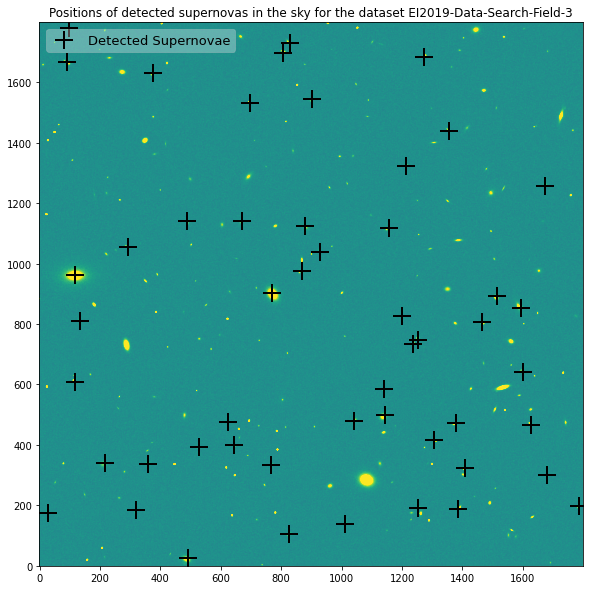

In [0]:
def tout_afficher(directory, globalname):
  image = fits.open(directory+globalname+'_images_epoch_-100.00_.fits')[0].data

  galaxies = pandas.read_csv(directory+globalname+"_galaxies.csv")

  plt.figure(figsize=(10,10))
  imshow(image, origin="lower", vmin=-3*np.std(image), vmax=3*np.std(image))
  
  allSNe = find_all_SNe(directory,globalname, 0)
  allSNe = clean_SNe(allSNe)
  redshifts = calculate_redshift(allSNe, directory, globalname)

  #plt.scatter(np.around(galaxies['x'].values), np.around(galaxies['y'].values), 
   #       s=300, marker='o', facecolors='none', edgecolors='r', lw=2,
    #        label='Galaxies')

  plt.scatter(allSNe[:,0], allSNe[:,1], s=300, marker='+', color='k', lw=2, label='Detected Supernovae')
  title("Positions of detected supernovas in the sky for the dataset " + globalname)
  legend(loc='upper left', fontsize=13, framealpha=0.3)
  candidates = pandas.DataFrame(np.transpose([allSNe[:,0], allSNe[:,1], redshifts]), columns=["Position X", "Position Y", "Redshift"])

  return(candidates)

candidats = tout_afficher(directory2,globalname2)
candidats.to_csv(directory2+globalname2+"_sn.csv")
candidats